In [0]:

## image processing packages
import os
import glob
import pickle
import base64
import numpy as np
from PIL import Image
from datetime import datetime
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

## web application packages
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template

In [0]:
####### (2) Mount the google drive so that we can access the images from google drive

from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
###### (3) Enter the working directory at Colab Notebooks and setup the working directories

work_dir = '/content/drive/My Drive/Colab Notebooks/csci5750_hw3_image_search/'

os.chdir(work_dir)
os.makedirs("images/cars/", exist_ok=True)
os.makedirs("features/cars/", exist_ok=True)
os.makedirs("uploaded/", exist_ok=True)
os.makedirs("templates/", exist_ok=True)


%pwd

'/content/drive/My Drive/Colab Notebooks/csci5750_hw3_image_search'

In [0]:
# Lists directory contents of files and directories.
# You are expected to view the following files/directories
# features/  hw03_image_search.ipynb  images/  templates/  uploaded/

%ls

features/  hw03_image_search.ipynb  images/  templates/  uploaded/


In [0]:
#### (4) Prepare feature extraction method, here we use pre-trained deep Learning network (VGG16) to get features for each image.

class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):  # img is from PIL.Image.open(path) or keras.preprocessing.image.load_img(path)
        img = img.resize((224, 224))  # VGG must take a 224x224 img as an input
        img = img.convert('RGB')  # Make sure img is color
        x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
        x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
        x = preprocess_input(x)  # Subtracting avg values for each pixel

        feature = self.model.predict(x)[0]  # Feed into VGG6 network to get high-level features 
        return feature / np.linalg.norm(feature)  # Normalize

####   To use this class for feature generation, we can use the following way to get feature vectors of an image

fe = FeatureExtractor()
img = Image.open('images/cars/acura_PNG71.png')  # PIL image
feature = fe.extract(img)
print(feature)
print("Dimension: ",feature.shape)
print("Min: ",feature.min())
print("Max: ",feature.max())
print("Average: ",feature.mean())

#### Therefore, each image can be represented as a vector of dimension 4096
#### Based on the vector, we can apply ML algorithms to learn the patterns.



#### Here is an exmaple to encode binary image data to printable ASCII characters for latter usage in web application.
with open('images/cars/acura_PNG71.png', "rb") as img_file:
        img_byte = base64.b64encode(img_file.read()).decode('utf-8')

print("ASCII characters of the image: ",img_byte)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0.         0.         0.         ... 0.00950012 0.         0.        ]
Dimension:  (4096,)
Min:  0.0
Max:  0.10992498
Average:  0.0056334855
ASCII characters of the image:  iVBORw0KGgoAAAANSUhEUgAAApYAAADMCAMAAAD+phOAAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAADAUExURQoKCg4ODgICAiMjIxMTEx4eHikpKS4uLhcXFxkZGTMzMzo6Oj8/P2BgYDc3N1dXV0lJSVBQUERERGpqagQEBAUFBREREQEBAQAAAAAAAAAAAAIBAXV1dQEBAYCAgAEBAQEBAQEBAf7+/oqKigEBARgYGJSUlNzc3evs7AEBAcLCws7OziQkJK2trZycnLe3t6SkpDs7O1RUVBkYGLq6uvGEhJCQkLKysj8DAsHBwcZPJG9sbH95eYQcDH1INAAAAJ0Tg3IAAABAdFJOU///////////////////////////HhIIK0vNvzr/Xv+vnYn//3PX////4f//1f/////Y1utI/8eG/7f/oWr//gBWSvawAABxjklEQVR42u2dCX+UyPb3i9opdnAXUUGbFuxljI/O/Gfm+v7f1fM5VQUUS3ei43bvSNTEmJhevn3qrL+DPv1Lrvfv37//6+PHj3/++eHDhw9VVVVlVVW73fF4Ppy6ruv6vvvjjz/++Pjx/fsHn35dP/ZC/8t37sH79x//+PDhQ1MURZRkaR7GcRAEcayUUkIp/V7FQZplSRKVVdMApsfz4Xw4aEL/+uv9+/u/IP2F5VeyjEBjVSRZHotY+JL5lEpfSunri7kXYcyHf5KSEUA1zZKoLAuwpVXVNA3Y0/P5cAZO//r48S8wu79Y/YXl5/D48eMfVVVkeUA4oZRSKX2L3m0XMZf5iHMBRjUM89xY0iiKCj

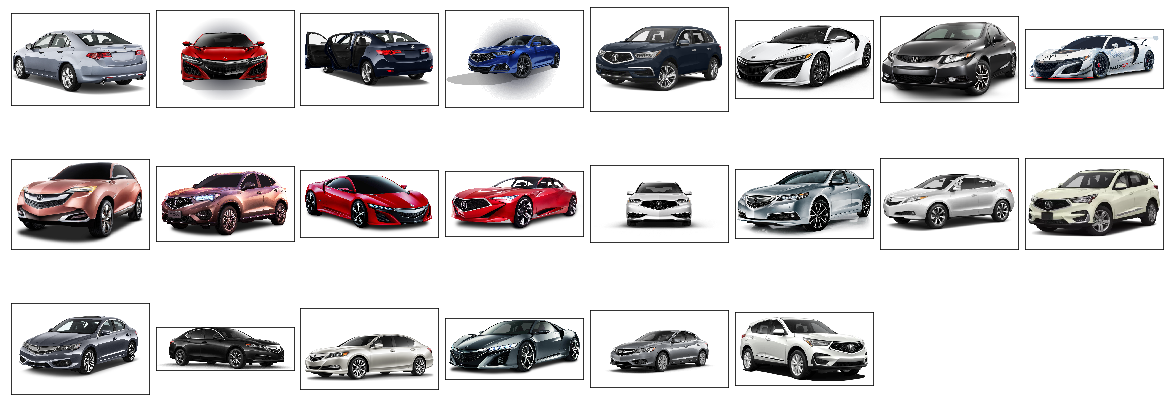

In [0]:
#### (5.a) Visualize text image set, make sure the images are uploaded to folder 'images/texts'
####       If you would like to apply this program to your own image dataset, you need put them in the different folders (i.e. images/cars).

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 16)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

i = 0
for img_path in sorted(glob.glob('images/cars/*.png')):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    img = Image.open(img_path)  # PIL image
    ax.imshow(img, cmap=plt.cm.binary, interpolation='nearest')
    i+=1
    img.close()

In [0]:
#### (5.b) Perform feature extraction for all images, saved in folder 'features/texts'
####       If you would like to apply this program to your own image dataset, you need put them in the different folders (i.e. features/cars).

fe = FeatureExtractor()
for img_path in sorted(glob.glob('images/cars/*.png')):
    img = Image.open(img_path)  # PIL image
    feature = fe.extract(img)
    feature_path = 'features/cars/' + os.path.splitext(os.path.basename(img_path))[0] + '.pkl'
    pickle.dump(feature, open(feature_path, 'wb'))
    img.close()
    print(os.path.splitext(os.path.basename(img_path))[0], ": Features are extracted.")

acura_PNG101 : Features are extracted.
acura_PNG102 : Features are extracted.
acura_PNG103 : Features are extracted.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


acura_PNG108 : Features are extracted.
acura_PNG111 : Features are extracted.
acura_PNG113 : Features are extracted.
acura_PNG117 : Features are extracted.
acura_PNG118 : Features are extracted.
acura_PNG119 : Features are extracted.
acura_PNG120 : Features are extracted.
acura_PNG121 : Features are extracted.
acura_PNG123 : Features are extracted.
acura_PNG125 : Features are extracted.
acura_PNG126 : Features are extracted.
acura_PNG127 : Features are extracted.
acura_PNG129 : Features are extracted.
acura_PNG130 : Features are extracted.
acura_PNG71 : Features are extracted.
acura_PNG78 : Features are extracted.
acura_PNG83 : Features are extracted.
acura_PNG94 : Features are extracted.
acura_PNG98 : Features are extracted.


Loading  /content/drive/My Drive/Colab Notebooks/csci5750_hw3_image_search/images/cars/acura_PNG118.png





Searching image against database:



Found similar figures:





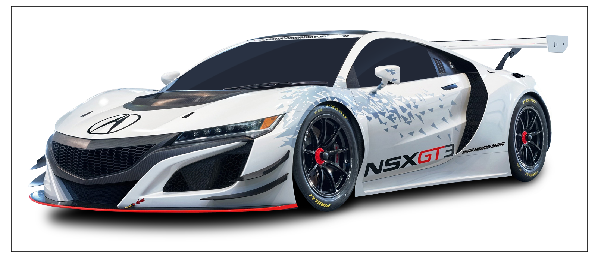

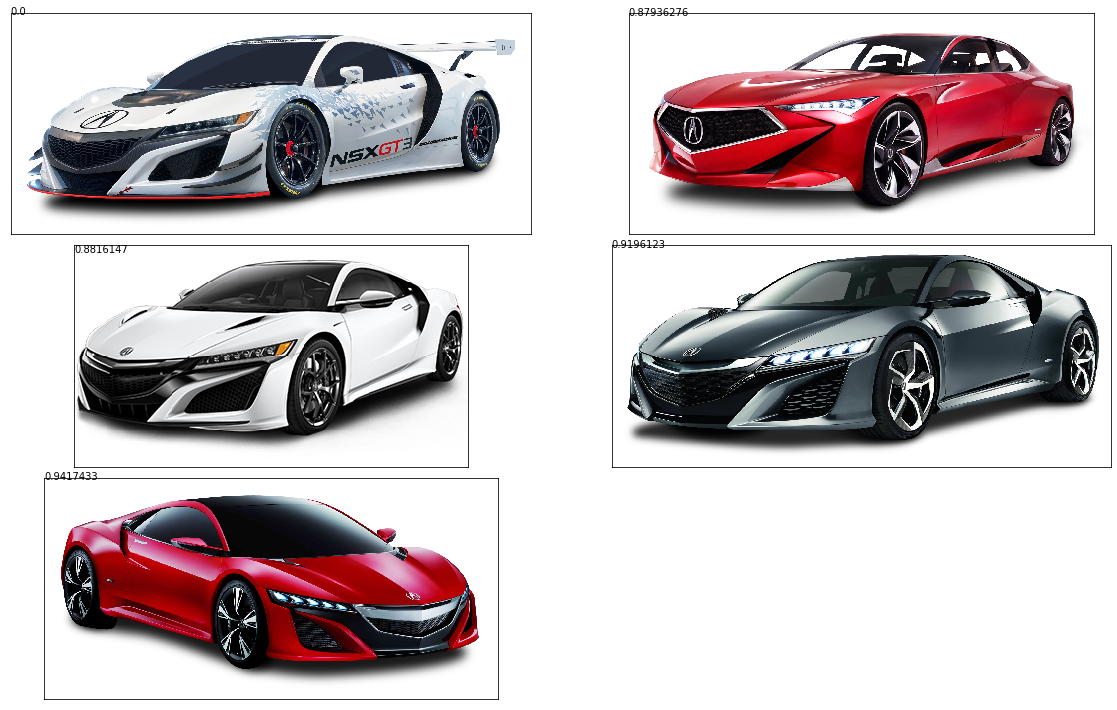

In [0]:
#### (6) Task: implement image search algorithm using L2-norm

# (1) Step 1: Read image features from "features/texts/*", and saved in list "img_features"
# (2) Step 2: Read image paths from "features/texts/*", and saved in list "img_paths"
# (3) Step 3: Get ASCII encoded from images from "features/texts/*", and saved in list "img_ASCIIs"
# (4) Step 4: Define the function to calculate the similarities between a query image and each image in image set
# (5) Step 5: Ramdomly sampling an image for function testing


# Loading image features, associated image filepath and encoded ASCII of image
# We use base64 module for encoding binary image data to printable ASCII characters for web application.

img_features = []
img_paths = []
img_ASCIIs = []

#### To communiate images between web and google drive, I convert images to bytes and send to web for visualization (this is easier) instead of letting web to read files from google drive directory (this is complex).
for feature_path in glob.glob("features/cars/*"):
    ### add image feature
    img_features.append(pickle.load(open(feature_path, 'rb')))

    ### add image path
    img_paths.append(work_dir+'images/cars/' + os.path.splitext(os.path.basename(feature_path))[0] + '.png')

    ### add image ASCII
    with open(work_dir+'images/cars/' + os.path.splitext(os.path.basename(feature_path))[0] + '.png', "rb") as img_file:
        img_byte = base64.b64encode(img_file.read()).decode('utf-8')
    img_ASCIIs.append(img_byte)



def calculate_similarity_L2norm(image_sets, query_image):
  scores = []
  distance = np.linalg.norm(image_sets - query_image, axis = 1)
  bestMatches = np.argsort(distance)[:5]
  for i in bestMatches:
    scores.append((distance[i], img_ASCIIs[i], img_paths[i]))

  return scores



#### Test your functions by randomly sampling an image and found its similar images

from random import sample 
sample_image = sample(img_paths,1)
print("Loading ",sample_image[0])
img_selected = Image.open(sample_image[0])  # PIL image

## visualize selected image
fig = plt.figure(figsize=(8, 8)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=
0.05)
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(img_selected, cmap=plt.cm.binary, interpolation='nearest')

## get feature for selectd image
from keras.backend import clear_session
clear_session()
fe = FeatureExtractor()
query = fe.extract(img_selected)

## search image against database
print("\n\n\nSearching image against database:\n\n\n")
scores = calculate_similarity_L2norm(img_features, query)  # Do search

## visualize the results
fig = plt.figure(figsize=(16, 16)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=
0.05)

i = 0
print("Found similar figures:\n\n\n")
for score,image_ASCII,image_file in scores:
    ax = fig.add_subplot(5, 2, i + 1, xticks=[], yticks=[])
    img = Image.open(image_file)  # PIL image
    ax.imshow(img, cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, str(score))
    i+=1
    img.close()

In [0]:
###### (7) Write webpage for front-end visualization

%%writefile templates/index.html
<!doctype html>
<html>
    <head><link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css"></head>
    <body>
        <div class="container">
            <h1>CSCI4750/5750: Homework03 ----- Simple image search algorithm</h1>
            <h2>Upload your image to search:</h2>
            <form method="POST" enctype="multipart/form-data">
                <input type="file" name="query_img"><br>
                <input type="submit">
            </form>
            <hr>
            <h2>Query image:</h2>
            {% if query_img_bytes %} <!--Send images as Base64String-->
            <img src="data:image/png;base64,{{ query_img_bytes }}" alt="Query Image"  width="300px">
            {% endif %}
            <h2>Algorithm Results:</h2>
            {% for score in scores %}
            <figure style="float: left; margin-right: 20px; margin-bottom: 20px;">
                <!--Send images as Base64String-->
                <img src="data:image/png;base64,{{ score[1] }}" alt="Results Image"  width="300px" height="150px">
                <figcaption>L2-norm score: {{ score[0] }}</figcaption>
            </figure>
            {% endfor %}
        </div>
    </body>
</html>

In [0]:
##### (8) Implement back-end and front-end application


from keras.backend import clear_session
clear_session()

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
graph = tf.get_default_graph()

def home():
    return render_template('index.html')

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        file = request.files['query_img']
        img = Image.open(file.stream)  # PIL image
        uploaded_img_path = work_dir+"uploaded/" + datetime.now().isoformat() + "_" + file.filename
        img.save(uploaded_img_path)
        with open(uploaded_img_path, "rb") as img_file:
          uploaded_img_byte = base64.b64encode(img_file.read()).decode('utf-8')
        
        #### Extract features
        global graph
        with graph.as_default():        
            img = img.resize((224, 224))
            img = img.convert('RGB')
            x = image.img_to_array(img)  # To np.array. Height x Width x Channel. dtype=float32
            x = np.expand_dims(x, axis=0)  # (H, W, C)->(1, H, W, C), where the first elem is the number of img
            x = preprocess_input(x)  # Subtracting avg values for each pixel

            feature = model.predict(x)[0]  # (1, 4096) -> (4096, )   
            query = feature / np.linalg.norm(feature)


            ############# For CSCI5750 students to change according to their new similarity measurements
            ''' 
            May need change here to calculate the distance between query and image sets
            '''
            scores = calculate_similarity_L2norm(img_features,query)
            #############

        return render_template('index.html',
                               query_img_bytes=uploaded_img_byte,
                               scores=scores)
    else:
        
        return render_template('index.html')


app.run() 